In [1]:
#Wczytaj tę komórkę - zawiera funkcje potrzebne do wczytania / przetwarzania danych 

import numpy as np
from urllib import request
import gzip
import pickle
import torch 
from torch import nn
import pandas as pd 
from matplotlib import pyplot as plt 

import random 
def shuffle_data(x, y):
    c = list(zip(x, y))
    random.shuffle(c)
    return zip(*c)

filename = [
    ["training_images","train-images-idx3-ubyte.gz"],
    ["test_images","t10k-images-idx3-ubyte.gz"],
    ["training_labels","train-labels-idx1-ubyte.gz"],
    ["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def preprocess(x):
    return [y.flatten()  for y in x]


def normalize(x):
    mean_val = np.mean(x)
    stdev_val = np.std(x)
    return (x - mean_val) / stdev_val

def binarize(y):
    return [int(elem == 5) for elem in y]
         

def load(n = 5000):
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return (
        normalize(preprocess(mnist["training_images"][:n]  / 255.)), 
        [x[0] for x in preprocess(mnist["training_labels"][:n])], 
        normalize(preprocess(mnist["test_images"][:n]  / 255.)), 
        [x[0] for x in preprocess(mnist["test_labels"][:n])]
    )

init()

Download complete.
Save complete.


In [2]:
# wczytaj tę komórkę. 
x_train, y_train, x_test, y_test = load()
x_train, y_train = zip(*[x for x in list(zip(x_train, y_train)) if x[1] == 5 or (random.random() < 0.12)])
x_test, y_test = zip(*[x for x in list(zip(x_test, y_test)) if x[1] == 5 or (random.random() < 0.12)])

y_train_bin = binarize(y_train)
y_test_bin = binarize(y_test) 


In [3]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()        
        self.mlp = nn.Sequential(
            nn.Linear(784, 50),
            nn.Sigmoid(),
            nn.Linear(50,15),
            nn.Sigmoid(),
            nn.Linear(15, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):        
        return self.mlp(x)


In [4]:
# training loop - pętla trenująca została zamknięta w funkcję train 

from tqdm import tqdm
def training_loop(model, optimizer, x_train, y_train, batch_size = 128, epochs=50):
    losses = []
    bce_loss = nn.BCELoss()
    for epoch in tqdm(range(epochs)):
        x, y = shuffle_data(x_train,y_train_bin)
        current_index = 0 
        while current_index < len(x_train):
            batch_x = x[current_index:(current_index + batch_size)]
            batch_y = y[current_index: (current_index + batch_size)] # 
            
            tensor_batch_x = torch.Tensor(batch_x)
            tensor_batch_y = torch.Tensor(batch_y).reshape(-1, 1)
            
            pred = model.forward(tensor_batch_x)
            loss = bce_loss(pred, tensor_batch_y)

                
            # Backpropagation
            loss.backward() # Liczenie gradientu wag modelu
            optimizer.step() # adam oblicza nowe parametry sieci 
            optimizer.zero_grad()
            
            current_index += batch_size
            losses.append(float(loss.detach().numpy()))
            
    return model, losses  # funkcja zwraca dwie wartości: nauczony model oraz listę losses(błędów) w każdej iteracji  


In [5]:
# Task 1.
model = MultiLayerPerceptron()
optimizer = torch.optim.Adam(model.parameters()) # TODO: wypróbuj optimizer Adam : torch.optim.Adam
trained_model, losses_adam = training_loop(model=model, optimizer = optimizer, x_train=x_train, y_train=y_train_bin, batch_size=256)


/home/kamil/work/hobby/ml7-kozm/mlcourse/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                                                   | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_19722/3826991665.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  tensor_batch_x = torch.Tensor(batch_x)
100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.55it/s]


In [6]:
# Task 2.
model = MultiLayerPerceptron()
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # TODO: wypróbuj optimzier SGD torch.optim.SGD poeksperymentuj z parametrem lr= [wypróbuj wartości 0.01, 0.05, 0.1, 0.2]
trained_model, losses_sgd = training_loop(model=model, optimizer = optimizer, x_train=x_train, y_train=y_train_bin, batch_size=256)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.07it/s]


In [7]:
# Task 3.
model = MultiLayerPerceptron()
optimizer = torch.optim.AdamW(model.parameters()) # TODO: wypróbuj AdamW torch.optim.AdamW 
trained_model,losses_adamw = training_loop(model=model, optimizer = optimizer, x_train=x_train, y_train=y_train_bin, batch_size=256)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.57it/s]


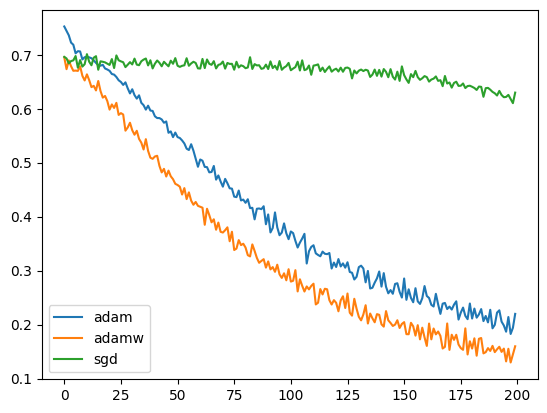

In [8]:
# TODO: Pokaż jak loss/error wszystkich trzech optimizerów zmienia się w czasie

pd.Series(losses_adam).plot(label='adam')
pd.Series(losses_adamw).plot(label='adamw')
pd.Series(losses_sgd).plot(label='sgd')
plt.legend()

In [11]:
# Task 3: Poeksperymentuj z różnymi parami sieci neuronowych i zobacz jak zmienia się loss po zmianie architektury sieci oraz funkcji aktywacji 

# Twój oryginalny perceptron 
class MultiLayerPerceptronA(nn.Module):
    def __init__(self):
        super().__init__()        
        self.mlp = nn.Sequential(
            nn.Linear(784, 50),
            nn.Sigmoid(),
            nn.Linear(50,15),
            nn.Sigmoid(),
            nn.Linear(15, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):        
        return self.mlp(x)

# Perceptron z którym go porównasz 
class MultiLayerPerceptronB(nn.Module):
    def __init__(self):
        super().__init__()        
        self.mlp = nn.Sequential(
            nn.Linear(784, 50), # TODO: Poeksperymentuj z różną ilością neuronów 
            nn.Sigmoid(),  # TODO: Zamień aktywacje na ReLU 
            nn.Linear(50,15),
            nn.Sigmoid(),  # TODO: Zamień aktywacje na ReLU 
            nn.Linear(15, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):        
        return self.mlp(x)


In [17]:
model = MultiLayerPerceptronA()
optimizer = torch.optim.Adam(model.parameters())
_, losses_a = training_loop(model=model, optimizer = optimizer, x_train=x_train, y_train=y_train_bin, batch_size=256)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.84it/s]


In [18]:
model = MultiLayerPerceptronB()
optimizer = torch.optim.Adam(model.parameters())
_ ,losses_b = training_loop(model=model, optimizer = optimizer, x_train=x_train, y_train=y_train_bin, batch_size=256)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.91it/s]


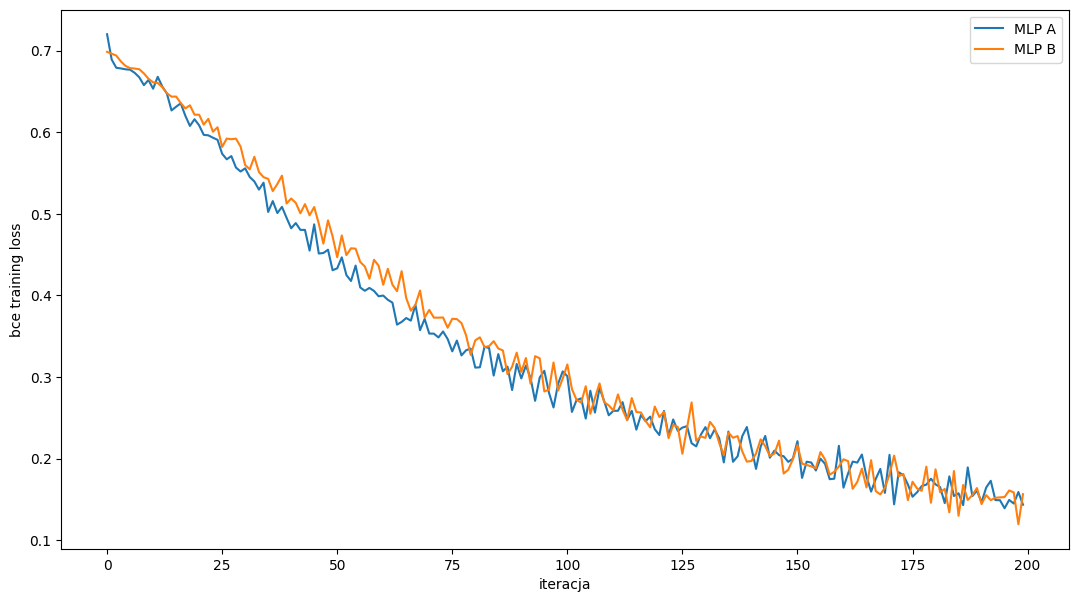

In [21]:
# Proces uczenia dla powyższych par A, B 
import pandas as pd 
from matplotlib import pyplot as plt 
plt.figure(figsize=(13,7))
plt.xlabel("iteracja")
plt.ylabel("bce training loss")
pd.Series(losses_a).plot(label='MLP A')
pd.Series(losses_b).plot(label='MLP B')
plt.legend()